## Calculate the Trophic Level using Stock et al. 2014. 
\begin{equation}
MESO_{ZP} = ZPC * NPP * ZGE^{MESO_{TL}}
\end{equation}
    Where: 
- `MESOZP` = combined production of all zooplankton groups
- `NPP` = Net primary production 
- `ZGE` = mean of zooplankton growth efficiencies from the zooplankton gropus. It does provides a bulk measure of costumer growth efficiency for the system. 
- `ZPC` = zooplankton-phytoplankton coupling efficiency - total ingestion of phytoplankton by all zooplankton gropus divided by total phytoplankton produciton. 

In [1]:
%matplotlib inline
import warnings
warnings.simplefilter("ignore") # Silence warnings
import xarray as xr
import cartopy.crs as ccrs
import numpy as np
import math
from matplotlib.pyplot import figure

# MatPlotlib
import matplotlib.pyplot as plt
from matplotlib import pylab

# Scientific libraries
from numpy import arange,array,ones
from scipy import stats
import seaborn as sns
import scipy.io as sio
import numpy.ma as ma
from netCDF4 import Dataset as NetCDFFile
import glob
import pylab 
from copy import deepcopy
import pandas as pd
import os
import matplotlib.gridspec as gridspec
import matplotlib
import cartopy
import matplotlib.colors as colors
import cmocean

In [2]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [3]:
def adjust_pop_grid(tlon,tlat,field):
    nj = tlon.shape[0]
    ni = tlon.shape[1]
    xL = int(ni/2 - 1)
    xR = int(xL + ni)

    tlon = np.where(np.greater_equal(tlon,np.min(tlon[:,0])),tlon-360.,tlon)
    lon  = np.concatenate((tlon,tlon+360.),1)
    lon = lon[:,xL:xR]

    if ni == 320:
        lon[367:-3,0] = lon[367:-3,0]+360.
    lon = lon - 360.
    lon = np.hstack((lon,lon[:,0:1]+360.))
    if ni == 320:
        lon[367:,-1] = lon[367:,-1] - 360.

    #-- trick cartopy into doing the right thing:
    #   it gets confused when the cyclic coords are identical
    lon[:,0] = lon[:,0]-1e-8

    #-- periodicity
    lat  = np.concatenate((tlat,tlat),1)
    lat = lat[:,xL:xR]
    lat = np.hstack((lat,lat[:,0:1]))

    field = np.ma.concatenate((field,field),1)
    field = field[:,xL:xR]
    field = np.ma.hstack((field,field[:,0:1]))
    return lon,lat,field

In [4]:
### 20 year climatology GNG513b from 43 to 62 representing Jan 1990 - Dec 2009.
path = '/glade/campaign/cesm/development/bgcwg/projects/marbl-spectra/GNG595_2ndcycle_1990-2009_clim'
files = sorted(glob.glob(f'{path}/*.nc', recursive=True),key=numericalSort)
ds= xr.open_mfdataset(files,combine='by_coords')

#### `Net primary production (NPP)` and `total primary production (TPP)` are both terms used to describe the process of converting solar energy into chemical energy through photosynthesis in plants. 
However, they differ in their specific definitions and what they represent.

- `Net Primary Production (NPP)`:
Net primary production refers to the total amount of energy or biomass that is produced by plants during photosynthesis, minus the amount of energy or biomass that is used by the plants for their own respiration (i.e., metabolic processes). In other words, NPP represents the energy or biomass that is available to support the growth and reproduction of primary producers (plants) in an ecosystem.
NPP takes into account the energy that is stored in plant tissues as organic matter (e.g., leaves, stems, roots) and can potentially be passed on to the next trophic level in the food chain. It is usually expressed in terms of energy (e.g., kilocalories per unit area) or biomass (e.g., grams per unit area) produced per unit area and per unit time (e.g., per year).

- `Total Primary Production (TPP)`:
Total primary production, on the other hand, refers to the total amount of energy or biomass that is produced by photosynthesis in an ecosystem, regardless of whether it is used by the plants themselves or stored as organic matter. TPP represents the entire amount of energy or biomass that is generated through photosynthesis.
TPP includes both the net primary production (NPP) and the energy or biomass that is consumed by plants through respiration (i.e., autotrophic respiration). It represents the total energy flow through the primary producer level in the ecosystem, including the energy that is retained by the plants for their own metabolic needs.

In summary, NPP specifically measures the energy or biomass available for growth and reproduction of plants, while TPP represents the total energy or biomass generated through photosynthesis, including what is used by the plants themselves. NPP is a more relevant measure when studying energy flow through ecosystems and assessing the potential productivity for higher trophic levels.

## Calculate `NPP`

##### `total primary production` and `total carbon fixation` refer to the same concept in ecology. 
Both terms describe the process by which green plants, algae, and some bacteria convert carbon dioxide (CO$_2$) and sunlight into organic matter through photosynthesis.

In [5]:
# Total C Fixation over the top 150m (Method 1) # mmol/m^3/s
total_prod = np.nansum(ds.photoC_TOT[:,:,:,:],axis=(1)) * 10 * (60*60*24) # mmol m-2 d-1
total_prod = np.nanmean(total_prod,axis=0) * 12.011 # mg/m^2/d -- annual mean

In [6]:
print('total phytoplankton production (Method 1) min is = ', np.nanmin(total_prod),' mgC m-2 d-1')
print('total phytoplankton production (Method 1) max is = ', np.nanmax(total_prod),' mgC m-2 d-1')

total phytoplankton production (Method 1) min is =  0.0  mgC m-2 d-1
total phytoplankton production (Method 1) max is =  3719.1993868567047  mgC m-2 d-1


In [7]:
# Total C Fixation over the top 150m (Method 2)
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = ['photoC_'+v+'_zint' for v in phyto_names]
phytoProd = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoProd = ((phytoProd / 100)) # units are mmol m-3 * m s-1
phytoProd = np.nansum(phytoProd,axis=0) * (60*60*24) * 12.011 # to mg C m-2 d-1
phytoProd = np.nanmean(phytoProd, axis=0)# annual mean

In [8]:
print('total phytoplankton production (Method 2) min is = ', np.nanmin(phytoProd),' mgC m-2 d-1')
print('total phytoplankton production (Method 2) max is = ', np.nanmax(phytoProd),' mgC m-2 d-1')

total phytoplankton production (Method 2) min is =  0.0  mgC m-2 d-1
total phytoplankton production (Method 2) max is =  3719.1992459116505  mgC m-2 d-1


#### Phytoplankton loss - linear loss and aggreagation loss 
- `linear loss` includes non-predation mortality and a collection of desnity-independent processes such as dissolved organic matter (DOM) exaudation, viral lysis, and cell death. 
- `aggregation loss` representes loss of phytoplankton due to aggregation and unresolved predation, and this loss goes directly to particulate organic matter (POC). 

In [9]:
# Loss Vertical Integral, mmol/m^3 cm/s
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'_loss_zint' for v in phyto_names]
phytoloss = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoloss = ((phytoloss / 100)) # units are mmol m-3 * m s-1
phytoloss = np.nansum(phytoloss,axis=(0)) * (60*60*24) * 12.011 # to mg C m-2 d-1
phytoloss = np.nanmean(phytoloss,axis=0) # annual mean

In [10]:
print('total phytoplankton loss min is = ', np.nanmin(phytoloss),' mgC m-2 d-1')
print('total phytoplankton loss max is = ', np.nanmax(phytoloss),' mgC m-2 d-1')

total phytoplankton loss min is =  0.0  mgC m-2 d-1
total phytoplankton loss max is =  258.8942666203016  mgC m-2 d-1


In [11]:
# Aggregation Vertical Integral, mmol/m^3 cm/s
phyto_names = ['pp','diaz','mp1','diat1','mp2','diat2','mp3','diat3','mp4']
phyto_vars = [''+v+'_agg_zint' for v in phyto_names]
phytoagg = xr.concat([ds[v] for v in phyto_vars], dim='var') # units are mmol m-3 * cm s-1
phytoagg = ((phytoagg / 100)) # units are mmol m-3 * m s-1
phytoagg = np.nansum(phytoagg,axis=(0)) * (60*60*24) * 12.011 # to mgC m-2 d-1
phytoagg = np.nanmean(phytoagg,axis=0) # annual mean

In [12]:
print('total phytoplankton aggregation min is = ', np.nanmin(phytoagg),' mgC m-2 d-1')
print('total phytoplankton aggregation max is = ', np.nanmax(phytoagg),' mgC m-2 d-1')

total phytoplankton aggregation min is =  0.0  mgC m-2 d-1
total phytoplankton aggregation max is =  2325.2876707881687  mgC m-2 d-1


In [13]:
total_npp = phytoProd- phytoloss

In [14]:
print('NPP min is = ', np.nanmin(total_npp),' mgC m-2 d-1')
print('NPP max is = ', np.nanmax(total_npp),' mgC m-2 d-1')

NPP min is =  0.0  mgC m-2 d-1
NPP max is =  3460.304979291349  mgC m-2 d-1


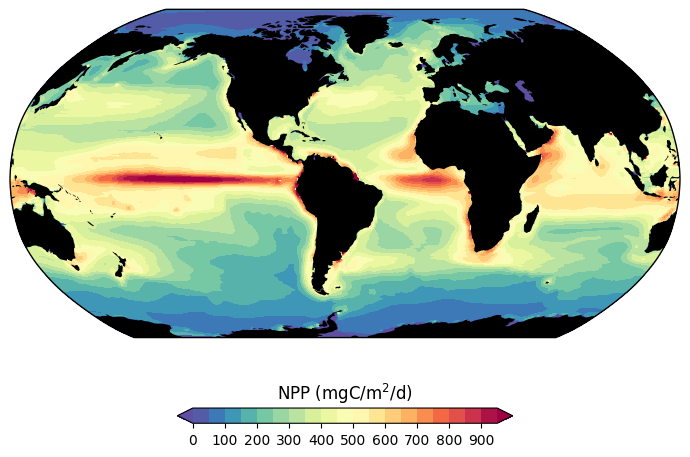

In [15]:
fig = plt.figure(figsize=(7, 5))
lev = np.arange(0, 1000, 50)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=500)
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, total_npp)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('NPP (mgC/m$^2$/d)')
#cb.ax.tick_params(labelsize=16)
fig.tight_layout()

Results are consistent with Stock et al. 2014 where NPP values range from 0 -1000 mg C m-2 d-1

## `MESOZP` = mesozooplankton production not consumed by other zooplankton
* Here, I will use zooplankton production - zooplankton grazing on zooplankton of each category

In [16]:
# sum of Zooplankton Grazing Gain Vertical Integral mol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooGraz'] = xr.concat([ds['x_graze_' + v + '_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zooGraz = np.nanmean(ds.zooGraz,axis=1) *(60*60*24) * 12.011 # to mgC / m^2 d, annual mean
zooGraz_TOT = np.nansum(zooGraz, axis=0) # adding all individual grazing values

In [17]:
print('mesozooplankton grazing gain min is = ', np.nanmin(zooGraz),' mgC m-2 d-1')
print('mesozooplankton grazing gain  max is = ', np.nanmax(zooGraz),' mgC m-2 d-1')

mesozooplankton grazing gain min is =  0.000544269379368778  mgC m-2 d-1
mesozooplankton grazing gain  max is =  145.86964459558948  mgC m-2 d-1


In [18]:
# zooplankton loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_loss_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zooloss = np.nanmean(ds.zooLoss,axis=1) *(60*60*24) * 12.011 # to mgC / m^2 d, annual mean
zooloss_TOT = np.nansum(zooloss, axis=0)# adding all individual loss values

In [19]:
print('mesozooplankton loss min is = ', np.nanmin(zooloss),' mgC m-2 d-1')
print('mesozooplankton loss  max is = ', np.nanmax(zooloss),' mgC m-2 d-1')

mesozooplankton loss min is =  0.0  mgC m-2 d-1
mesozooplankton loss  max is =  82.1224414575845  mgC m-2 d-1


In [20]:
# zooplankton Linear loss vertical Intergral mmol/m^3 cm/s
zoo_names = ['zoo3','zoo4','zoo5','zoo6']
ds['zooLoss'] = xr.concat([ds[''+ v + '_linear_loss_zint'] for v in zoo_names], dim='var')* 1e-2 # units are mmol m-2 s-1
zoo_lin_loss = np.nanmean(ds.zooLoss,axis=1) *(60*60*24) * 12.011 # to mgC / m^2 d, annual mean
zoo_lin_loss_TOT = np.nansum(zoo_lin_loss, axis=0) # adding all individual loss values

In [21]:
print('mesozooplankton linear loss min is = ', np.nanmin(zoo_lin_loss),' mgC m-2 d-1')
print('mesozooplankton linear loss  max is = ', np.nanmax(zoo_lin_loss),' mgC m-2 d-1')

mesozooplankton linear loss min is =  0.0  mgC m-2 d-1
mesozooplankton linear loss  max is =  48.758349711599294  mgC m-2 d-1


In [22]:
zooProduction = np.subtract(zooGraz_TOT, zoo_lin_loss_TOT)
zooProduction[zooProduction<0]=0

print('mesozooplankton production min is = ', np.nanmin(zooProduction),' mgC m-2 d-1')
print('mesozooplankton production  max is = ', np.nanmax(zooProduction),' mgC m-2 d-1')

mesozooplankton production min is =  0.0  mgC m-2 d-1
mesozooplankton production  max is =  107.45330217613082  mgC m-2 d-1


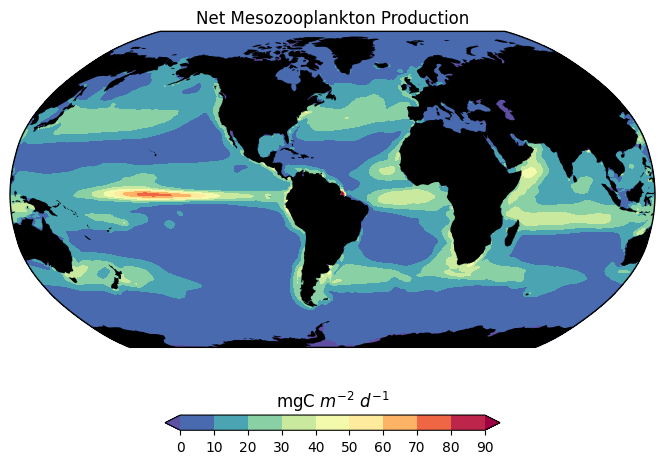

In [23]:
lev = np.arange(0, 100, 10)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=50)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, zooProduction)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
cb.ax.set_title('mgC $m^{-2}$ $d^{-1}$')
ax.set_title('Net Mesozooplankton Production');
plt.tight_layout()

Similar, but less zooplankton production than Stock et al. 2014, however we knew this about MARBL-SPECTRA already

## Calculate `ZGE` = mean of zooplankton growth efficiencies from the zooplankton groups. It does provides a bulk measure of costumer growth efficiency for the system. 

The `Zooplankton Growth Efficiency` is the ratio of net zooplankton production to ingestion, is thus negative at very low ingestion rates (i,e) there is a net loss of carbon to respiration) before increasing toward an asympotic maximum just below 40% as in observations of Straile (1997) and Hansen et al. (1997). 

\begin{equation}
ZGE = \frac{net~zooplankton~production}{ingestion}
\end{equation}

### Zooplankton growth efficiency
- In total, ~30% of ingested material is egested, yielding an assimilation efficiency (ae) of 70% (Carlotti et al. 2000; Nagata, 2000). An additional 30% of ingestion is allocated to active metabolism (i.e., metabolic costs associated with feeding), leaving 40% to cover basel metabolic costs and support production (i.e., growth and reproduction). 

### `Zooplankton ingestion`

#### `Zooplankton 1`

In [24]:
graze_zoo1 = ['diaz_zoo1','pp_zoo1','mp1_zoo1','diat1_zoo1']

graze_vars = ['graze_'+v+'' for v in graze_zoo1]
ingestion_zoo1 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo1 = np.nansum(ingestion_zoo1[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m
ingestion_zoo1 = np.nanmean(ingestion_zoo1,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo1 min is = ', np.nanmin(ingestion_zoo1),' mgC m-2 d-1')
print('ingestion_zoo1  max is = ', np.nanmax(ingestion_zoo1),' mgC m-2 d-1')

ingestion_zoo1 min is =  0.0  mgC m-2 d-1
ingestion_zoo1  max is =  165.84603887032716  mgC m-2 d-1


#### `Zooplankton 2`

In [25]:
graze_zoo2 = ['diaz_zoo2','mp1_zoo2','mp2_zoo2',
             'diat1_zoo2','diat2_zoo2','zoo1_zoo2']

graze_vars = ['graze_'+v+'' for v in graze_zoo2]
ingestion_zoo2 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo2 = np.nansum(ingestion_zoo2[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo2 = np.nanmean(ingestion_zoo2,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo2 min is = ', np.nanmin(ingestion_zoo2),' mgC m-2 d-1')
print('ingestion_zoo2  max is = ', np.nanmax(ingestion_zoo2),' mgC m-2 d-1')

ingestion_zoo2 min is =  0.0  mgC m-2 d-1
ingestion_zoo2  max is =  7.758793545323715  mgC m-2 d-1


#### `Zooplankton 3`

In [26]:
graze_zoo3 = ['diaz_zoo3','mp2_zoo3','mp3_zoo3',
               'diat1_zoo3','diat2_zoo3','diat3_zoo3',
               'zoo1_zoo3','zoo2_zoo3']

graze_vars = ['graze_'+v+'' for v in graze_zoo3]
ingestion_zoo3 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo3 = np.nansum(ingestion_zoo3[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo3 = np.nanmean(ingestion_zoo3,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo3 min is = ', np.nanmin(ingestion_zoo3),' mgC m-2 d-1')
print('ingestion_zoo3  max is = ', np.nanmax(ingestion_zoo3),' mgC m-2 d-1')

ingestion_zoo3 min is =  0.0  mgC m-2 d-1
ingestion_zoo3  max is =  145.83346198657526  mgC m-2 d-1


#### `Zooplankton 4`

In [27]:
graze_zoo4 = ['mp2_zoo4','mp3_zoo4',
             'mp4_zoo4','diat1_zoo4','diat2_zoo4','diat3_zoo4','zoo2_zoo4','zoo3_zoo4']

graze_vars = ['graze_'+v+'' for v in graze_zoo4]
ingestion_zoo4 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo4 = np.nansum(ingestion_zoo4[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo4 = np.nanmean(ingestion_zoo4,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo4 min is = ', np.nanmin(ingestion_zoo4),' mgC m-2 d-1')
print('ingestion_zoo4  max is = ', np.nanmax(ingestion_zoo4),' mgC m-2 d-1')

ingestion_zoo4 min is =  0.0  mgC m-2 d-1
ingestion_zoo4  max is =  6.111785458265512  mgC m-2 d-1


#### `Zooplankton 5`

In [28]:
graze_zoo5 = ['mp3_zoo5','mp4_zoo5','diat2_zoo5','diat3_zoo5',
            'zoo3_zoo5','zoo4_zoo5']

graze_vars = ['graze_'+v+'' for v in graze_zoo5]
ingestion_zoo5 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo5 = np.nansum(ingestion_zoo5[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo5 = np.nanmean(ingestion_zoo5,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo5 min is = ', np.nanmin(ingestion_zoo5),' mgC m-2 d-1')
print('ingestion_zoo5  max is = ', np.nanmax(ingestion_zoo5),' mgC m-2 d-1')

ingestion_zoo5 min is =  0.0  mgC m-2 d-1
ingestion_zoo5  max is =  9.564702237481832  mgC m-2 d-1


#### `Zooplankton 6`

In [29]:
graze_zoo6 = ['mp4_zoo6','diat3_zoo6','zoo4_zoo6','zoo5_zoo6']

graze_vars = ['graze_'+v+'' for v in graze_zoo6]
ingestion_zoo6 = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion_zoo6 = np.nansum(ingestion_zoo6[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion_zoo6 = np.nanmean(ingestion_zoo6,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion_zoo6 min is = ', np.nanmin(ingestion_zoo6),' mgC m-2 d-1')
print('ingestion_zoo6  max is = ', np.nanmax(ingestion_zoo6),' mgC m-2 d-1')

ingestion_zoo6 min is =  0.0  mgC m-2 d-1
ingestion_zoo6  max is =  1.117092395610598  mgC m-2 d-1


In [30]:
# Ingestion rates for individual zooplankton 
inegestion_zoo = np.stack([ingestion_zoo3,
                          ingestion_zoo4,ingestion_zoo5,ingestion_zoo6],axis=0)

In [31]:
print('zooplankton ingestion min is = ', np.nanmin(inegestion_zoo),' mgC m-2 d-1')
print('zooplankton ingestion  max is = ', np.nanmax(inegestion_zoo),' mgC m-2 d-1')

zooplankton ingestion min is =  0.0  mgC m-2 d-1
zooplankton ingestion  max is =  145.83346198657526  mgC m-2 d-1


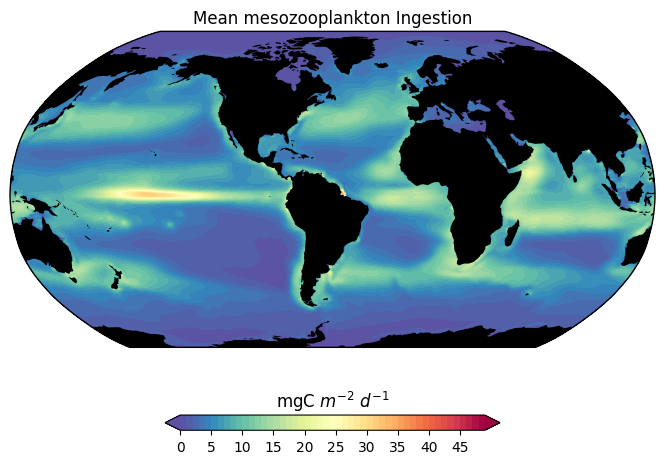

In [32]:
lev = np.arange(0, 50, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=25)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(inegestion_zoo,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Mean mesozooplankton Ingestion');
cb.ax.set_title('mgC $m^{-2}$ $d^{-1}$')
plt.tight_layout()

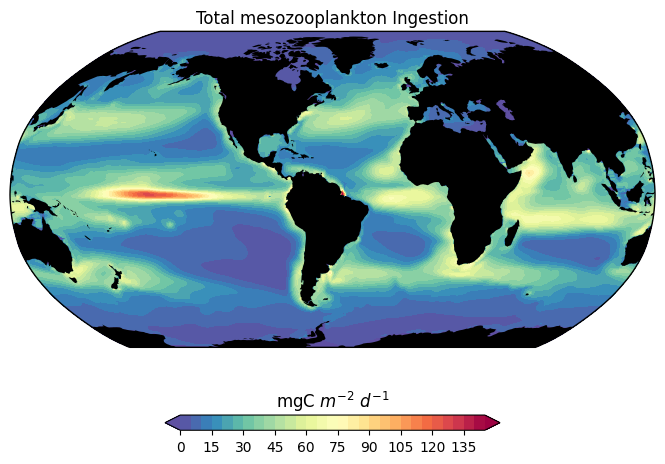

In [33]:
lev = np.arange(0, 150, 5)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=75)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nansum(inegestion_zoo,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Total mesozooplankton Ingestion');
cb.ax.set_title('mgC $m^{-2}$ $d^{-1}$')
plt.tight_layout()

In [34]:
## Zooplankton Production for individual zooplankton 
zooProd = np.subtract(zooGraz, zoo_lin_loss)
zooProd[zooProd<0]=0

In [35]:
print('zooplankton production min is = ', np.nanmin(zooProd),' mgC m-2 d-1')
print('zooplankton production  max is = ', np.nanmax(zooProd),' mgC m-2 d-1')

zooplankton production min is =  0.0  mgC m-2 d-1
zooplankton production  max is =  98.33608979025156  mgC m-2 d-1


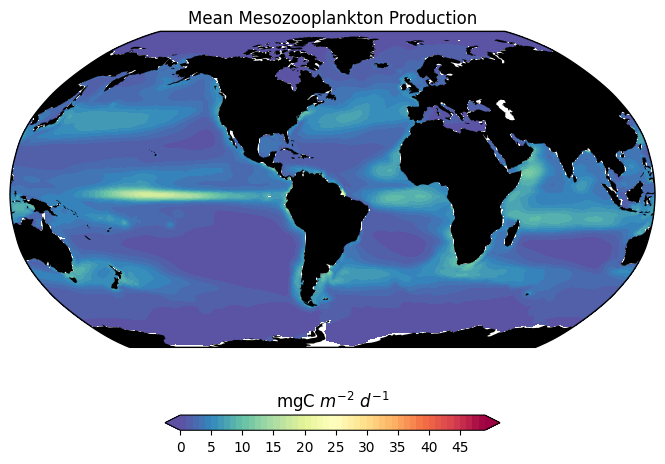

In [36]:
lev = np.arange(0, 50, 1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=25)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, np.nanmean(zooProd,axis=0))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Mean Mesozooplankton Production');
cb.ax.set_title('mgC $m^{-2}$ $d^{-1}$')
plt.tight_layout()

In [37]:
# Calculate the mesozooplankton growth efficiency
ZGE = (np.nansum(zooProd,axis=0)/np.nansum(inegestion_zoo,axis=0))
print('ZGE min is = ', np.nanmin(ZGE), ',unitless')
print('ZGE max is = ', np.nanmax(ZGE), ',unitless')

ZGE min is =  0.0 ,unitless
ZGE max is =  0.7312430953004676 ,unitless


`Zooplankton growth efficiency` refers to the efficiency with which zooplankton convert the energy they obtain from consuming phytoplankton or other food sources into their own biomass growth. It is typically expressed as the ratio of zooplankton biomass production to the biomass of the food they consume.

`If the zooplankton growth efficiency is greater than 1, it implies that the zooplankton are producing more biomass than the amount of food they consume`. This scenario is generally not observed in natural ecosystems because it would violate the principle of energy conservation. According to the laws of thermodynamics, energy cannot be created or destroyed, only transformed or transferred.

However, it's important to note that there might be instances where apparent growth efficiency exceeds 1 due to factors such as measurement errors or incomplete understanding of the system. In reality, the growth efficiency of zooplankton is typically less than 1, indicating that they convert only a fraction of the energy they consume into their own biomass growth. This inefficiency is attributed to metabolic losses, respiration, and energy expenditures for various physiological processes, locomotion, and reproduction.

In summary, `if the zooplankton growth efficiency is reported to be greater than 1, it is likely an anomaly or an error in measurement rather than a reflection of actual biological processes.`

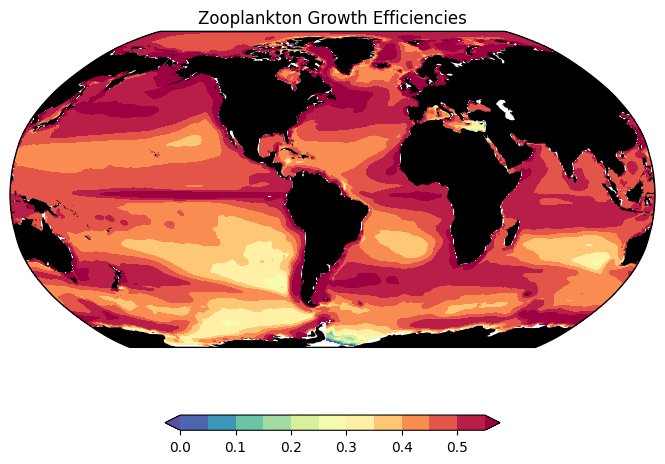

In [38]:
lev = np.arange(0, 0.6, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.3)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, ZGE)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Zooplankton Growth Efficiencies');
plt.tight_layout()

## Calculate `ZPC`= zooplankton-phytoplankton coupling efficiency - total ingestion of phytoplankton by all zooplankton gropus divided by total phytoplankton produciton. 

In [39]:
graze_names = ['diaz_zoo1','diaz_zoo2','diaz_zoo3','pp_zoo1','mp1_zoo1','mp1_zoo2',
            'mp2_zoo2','mp2_zoo3','mp2_zoo4','mp3_zoo3','mp3_zoo4','mp3_zoo5',
             'mp4_zoo4','mp4_zoo5','mp4_zoo6','diat1_zoo1','diat1_zoo2','diat1_zoo3',
            'diat1_zoo4','diat2_zoo2','diat2_zoo3','diat2_zoo4','diat2_zoo5',
             'diat3_zoo3','diat3_zoo4','diat3_zoo5','diat3_zoo6']

graze_vars = ['graze_'+v+'' for v in graze_names]
ingestion = xr.concat([ds[v] for v in graze_vars], dim='var') # units are mmol/m^3/s
ingestion = np.nansum(ingestion[:,:,:,:,:], axis=(0,2))* 10 # sum though the variables and the depth levels on the top 150m # mmolC m-2 s-1
ingestion = np.nanmean(ingestion,axis=0) * (60*60*24) * 12.011 # mgC m-2 d-1, annual mean

print('ingestion min is = ', np.nanmin(ingestion),' mgC m-2 d-1')
print('ingestion max is = ', np.nanmax(ingestion),' mgC m-2 d-1')

ingestion min is =  0.0  mgC m-2 d-1
ingestion max is =  209.9794439877849  mgC m-2 d-1


In [40]:
# Phytoplankton Production from earlier in the script
print('phytoProd min is = ', np.nanmin(phytoProd),' mgC m-2 d-1')
print('phytoProd max is = ', np.nanmax(phytoProd),' mgC m-2 d-1')

phytoProd min is =  0.0  mgC m-2 d-1
phytoProd max is =  3719.1992459116505  mgC m-2 d-1


In [41]:
ZPC = (ingestion/phytoProd)
print('ZPC min is = ', np.nanmin(ZPC), ',unitless')
print('ZPC max is = ', np.nanmax(ZPC), ',unitless')

ZPC min is =  0.04492294710887773 ,unitless
ZPC max is =  0.3772981399577245 ,unitless


In [42]:
ZPC = (ingestion/total_npp)
print('ZPC min is = ', np.nanmin(ZPC), ',unitless')
print('ZPC max is = ', np.nanmax(ZPC), ',unitless')

ZPC min is =  0.04741448254884635 ,unitless
ZPC max is =  0.6180678045646107 ,unitless


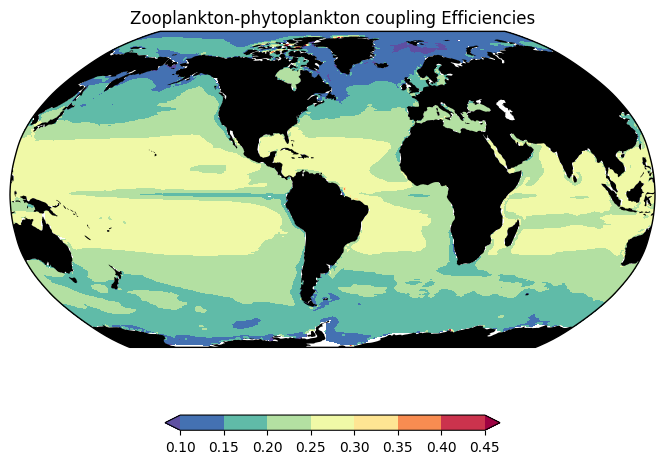

In [43]:
lev = np.arange(0.1, 0.5, 0.05)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=0.3)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, ZPC)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r',levels = lev, norm = norm, extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Zooplankton-phytoplankton coupling Efficiencies');
plt.tight_layout()

## Calculate the trophic level 
\begin{equation}
MESO_{TL} = \frac{ln(\frac{MESO_{ZP}}{(ZPC*NPP)})}{ln(ZGE)}
\end{equation}

In [44]:
nominator = zooProduction/(ZPC*total_npp)
print('nominator min is = ', np.nanmin(nominator), ',unitless')
print('nominator max is = ', np.nanmax(nominator), ',unitless')

denominator = ZGE
print('denominator min is = ', np.nanmin(denominator), ',unitless')
print('denominator max is = ', np.nanmax(denominator), ',unitless')

nominator min is =  0.0 ,unitless
nominator max is =  0.5938705531075043 ,unitless
denominator min is =  0.0 ,unitless
denominator max is =  0.7312430953004676 ,unitless


In [45]:
nominator[nominator==0]=1
log_nominator = ma.log(nominator)
print('log_nominator min is = ', np.nanmin(log_nominator))
print('log_nominator max is = ', np.nanmax(log_nominator))


denominator[denominator==0]=1
log_denominator = ma.log(denominator)
print('log_denominator min is = ', np.nanmin(log_denominator))
print('log_denominator max is = ', np.nanmax(log_denominator))

log_nominator min is =  -7.047745989034806
log_nominator max is =  0.0
log_denominator min is =  -6.465842003833933
log_denominator max is =  0.0


In [46]:
zoo_TL = log_nominator/log_denominator
print('zoo_TL min is = ', np.nanmin(zoo_TL))
print('zoo_TL max is = ', np.nanmax(zoo_TL))

zoo_TL min is =  0.0
zoo_TL max is =  4.4749149194150295


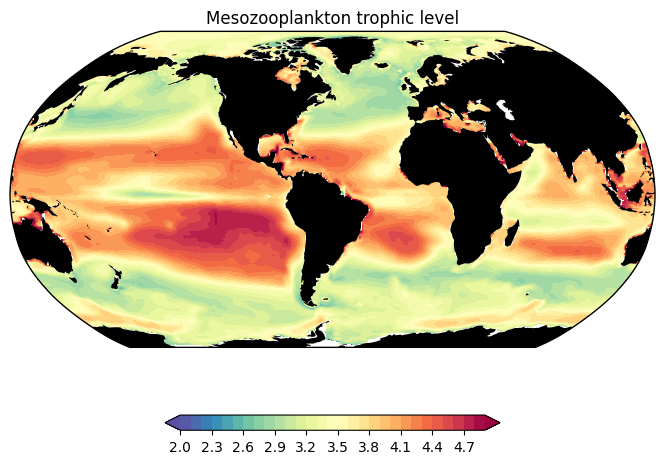

In [47]:
lev = np.arange(2, 5, 0.1)
norm = colors.TwoSlopeNorm(vmin=lev[0], vmax=lev[-1], vcenter=3.5)

fig = plt.figure(figsize=(7, 5))
lon, lat, zoo = adjust_pop_grid(ds.TLONG, ds.TLAT, 1+zoo_TL)
ax = fig.add_subplot(1, 1, 1, projection=ccrs.Robinson(central_longitude=305.0))
cf = ax.contourf(lon, lat, zoo, cmap='Spectral_r', levels = lev, norm = norm,extend = 'both',transform=ccrs.PlateCarree());
land = ax.add_feature(cartopy.feature.NaturalEarthFeature('physical','land','110m', facecolor='black'))
cb = plt.colorbar(cf, shrink=0.5, orientation='horizontal')
ax.set_title('Mesozooplankton trophic level');
plt.tight_layout()

### Results 
These results are consistent with the other trophic scaling method that uses grazing fluxes, where avergae zooplankton trophic levels are highest in the oligotrophic subtropical gyres and lowest in polar regions around the Southern Ocean and the Arctic Ocean. 